# Description

This open-source notebook contains the analysis presented in Wang LL et al., "A bibliometric analysis of citation diversity in accessibility and HCI research", CHI LBW '21.

## Imports and setting up

In [4]:
import os, sys
import json
import csv
import gzip
import itertools
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from cycler import cycler
from typing import List
import seaborn as sns
from pandas import DataFrame
import pandas as pd
import matplotlib as mpl
from matplotlib.patches import Patch

os.chdir('../')

from biblio.utils.list_utils import flatten
from biblio.load_dataset import load_dataset
from biblio.load_fos import MagLookup
from biblio.constants import VENUES_TO_PLOT


loading dblp data; this will take a moment...


In [5]:
# Plotting colors
tableau20 = [
    (31, 119, 180), (255, 127, 14), (255, 187, 120),
    (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
    (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
    (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
    (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)
]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20blind)):
    r, g, b = tableau20blind[i]
    tableau20blind[i] = (r / 255., g / 255., b / 255.)
    
# Color-line cycler
cycler_cl = cycler('linestyle', ['-', '--', ':', '-.', '-', '--']) * cycler('color', tableau20blind)

## Datasets

Several of these datasets are too large for GitHub and must be downloaded separately. See main README for instructions.

In [9]:
DATASET_DIR = "data"
DBLP_CONTAINER_METADATA = os.path.join(DATASET_DIR, 'dblp_container_meta.json')
ACCESSIBILITY_BIBLIOMETRICS_DATASET = os.path.join(DATASET_DIR, 'analysis', 'a11y_bibliometrics_dataset.jsonl.gz')
MAG_FOS_DATASET = os.path.join(DATASET_DIR, 'analysis', 'a11y_bibliometrics_mag_fos.jsonl.gz')

In [10]:
# load dblp container metadata
print('Loading DBLP container metadata...')
dblp_info = dict()
with open(DBLP_CONTAINER_METADATA, 'r') as f:
    for line in f:
        entry = json.loads(line)
        dblp_info[entry['key']] = entry
    
# load dataset
print('Loading main bibliometrics dataset (this takes a while)...')
core, extended, lookup = load_dataset(ACCESSIBILITY_BIBLIOMETRICS_DATASET)

# mag lookup
print('Loading MAG field of study lookup...')
mag_lookup = MagLookup(MAG_FOS_DATASET)

Loading DBLP container metadata...
Loading main bibliometrics dataset...
loading data...
generating paper list...
generate special a11y subsets...
forming lookup tables...
Loading MAG field of study lookup...


## Summary statistics

In [27]:
# Some stats about each comparative venue
print('VENUE\t\tPAPERS\tYEAR_RANGE\tNO_DOI\tNO_FOS')
print('------------------------------------------------------')
for i, venue in enumerate(VENUES_TO_PLOT):
    papers_by_year, no_year = lookup.get_papers_in_venue_by_year(venue)
    years = sorted(papers_by_year.keys())
    counts = [len(papers_by_year[yr]) for yr in years]
    venue_papers = flatten(papers_by_year.values())
    no_doi = [p for p in venue_papers if not p.doi]
    no_fos = [p for p in venue_papers if not p.fos]
    print(f"{venue}\t{sum(counts)}\t{min(years)}--{max(years)}\t{len(no_doi)}\t{len(no_fos)} ({100*len(no_fos)/len(venue_papers):.1f})")
    

VENUE		PAPERS	YEAR_RANGE	NO_DOI	NO_FOS
------------------------------------------------------
conf/assets	1492	1994--2020	2	203 (13.6)
conf/chi	19108	1981--2020	186	3657 (19.1)
conf/hci	18561	1987--2020	223	9143 (49.3)
conf/huc	3740	1999--2020	11	1328 (35.5)
conf/cscw	2636	1986--2020	15	448 (17.0)
conf/iui	2092	1993--2020	5	572 (27.3)
conf/uist	2182	1988--2020	5	293 (13.4)
conf/icchp	2078	1994--2020	0	979 (47.1)
conf/ACMdis	1842	1995--2020	14	264 (14.3)
conf/ozchi	1386	2006--2019	0	428 (30.9)
conf/tei	1349	2007--2020	3	220 (16.3)
conf/acmidc	1348	2003--2020	5	233 (17.3)
conf/nordichi	1266	2002--2020	13	387 (30.6)


## CHI/ASSETS reference and citation counts

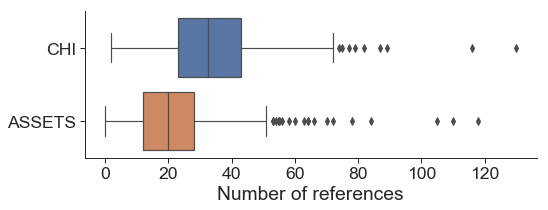

In [28]:
# box and whiskers for core set reference counts
sns.set_theme(style="ticks")

data_refs = [('References', dblp_info[p.venue]['acronym'], len(p.refs)) for p in core['a11y']]
data_cits = [('Citations', dblp_info[p.venue]['acronym'], len(p.cits)) for p in core['a11y']]
        
df_refs = DataFrame(data_refs, columns=['Type', 'Venue', 'Number of references'])
df_cits = DataFrame(data_cits, columns=['Type', 'Venue', 'Number of citations'])

df = DataFrame(data_refs + data_cits, columns=['Type', 'Venue', 'Number'])

# REFERENCES
plt.close()
sns.set_context("paper", font_scale=2) 
g = sns.catplot(
    x="Number of references", 
    y="Venue",
    kind="box", 
    data=df_refs,
    height=3, aspect=8/3
)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_ylabel('')
    
plt.show()

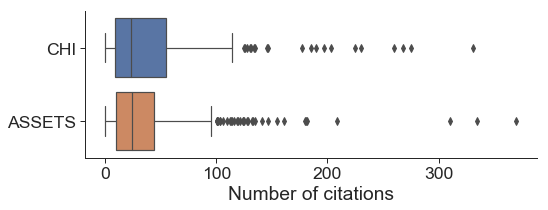

In [29]:
# And citation counts
plt.close()
sns.set_context("paper", font_scale=2) 
g = sns.catplot(
    x="Number of citations", 
    y="Venue",
    kind="box", 
    data=df_cits,
    height=3, aspect=8/3
)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_ylabel('')
    
plt.show()

## Top referenced and citing venues for accessibility papers in core set

In [30]:
# Set up dataframe

def normalize_legend_name(name_str):
    if '/' in name_str:
        if 'graphicsinterface' in name_str:
            return 'Graphics Interface'
        elif 'behaviourIT' in name_str:
            return 'BehaviourIT'
        else:
            return name_str.split('/')[-1].upper()
    name_str = name_str.replace('Journal', 'J')
    name_str = name_str.replace('Proceedings', 'Proc')
    name_str = name_str.replace('Rehabilitation', 'Rehab')
    name_str = name_str.replace('rehabilitation', 'rehab')
    name_str = name_str.replace('Impairment', 'Impair')
    name_str = name_str.replace('Visual', 'Vis')
    name_str = name_str.replace('developmental', 'dev')
    name_str = name_str.replace('Assistive', 'Assist')
    name_str = name_str.replace('assistive', 'assist')
    name_str = name_str.replace('technology', 'tech')
    name_str = name_str.replace('Technology', 'Tech')
    name_str = name_str.replace('Augmentative and Alternative Communication', 'AAC')
    name_str = name_str.replace('Transactions', 'Trans')
    name_str = name_str.replace('Engineering', 'Eng')
    
    if ':' in name_str:
        return name_str.split(':')[0].strip()
    if len(name_str) > 18:
        return name_str[:18].strip() + '..'
    return name_str

# histogram
top_k = 30

# Most commonly referenced and citing papers
a11y_assets_refs = flatten([paper.refs for paper in core['a11y_assets']])
a11y_assets_cits = flatten([paper.cits for paper in core['a11y_assets']])

a11y_chi_refs = flatten([paper.refs for paper in core['a11y_chi']])
a11y_chi_cits = flatten([paper.cits for paper in core['a11y_chi']])

a11y_assets_ref_papers = [lookup.get_paper_by_triple(tuple(ref)) for ref in a11y_assets_refs if ref]
a11y_assets_cit_papers = [lookup.get_paper_by_triple(tuple(cit)) for cit in a11y_assets_cits if cit]

a11y_chi_ref_papers = [lookup.get_paper_by_triple(tuple(ref)) for ref in a11y_chi_refs if ref]
a11y_chi_cit_papers = [lookup.get_paper_by_triple(tuple(cit)) for cit in a11y_chi_cits if cit]

a11y_all_ref_venues = [('ASSETS', p.venue) for p in a11y_assets_ref_papers] + \
    [('CHI', p.venue) for p in a11y_chi_ref_papers]
a11y_all_cit_venues = [('ASSETS', p.venue) for p in a11y_assets_cit_papers] + \
    [('CHI', p.venue) for p in a11y_chi_cit_papers]

ref_counts = Counter([entry[1] for entry in a11y_all_ref_venues])
cit_counts = Counter([entry[1] for entry in a11y_all_cit_venues])

top_k_ref_venues = [v_str for v_str, count in ref_counts.most_common(top_k + 1) if v_str]
top_k_cit_venues = [v_str for v_str, count in cit_counts.most_common(top_k + 1) if v_str]

bars_to_plot_refs = []
bars_to_plot_cits = []

for v_str in top_k_ref_venues:
    norm_venue_str = normalize_legend_name(v_str)
    num_refs_assets = sum([1 for p in a11y_assets_ref_papers if p.venue == v_str])
    num_refs_chi = sum([1 for p in a11y_chi_ref_papers if p.venue == v_str])
    bars_to_plot_refs.append((
        'References', 
        norm_venue_str, 
        num_refs_assets, 
        num_refs_chi, 
        num_refs_assets + num_refs_chi
    ))
    
for v_str in top_k_cit_venues:
    norm_venue_str = normalize_legend_name(v_str)
    num_cits_assets = sum([1 for p in a11y_assets_cit_papers if p.venue == v_str])
    num_cits_chi = sum([1 for p in a11y_chi_cit_papers if p.venue == v_str])
    bars_to_plot_cits.append((
        'Citations', 
        norm_venue_str, 
        num_cits_assets, 
        num_cits_chi, 
        num_cits_assets + num_cits_chi
    ))

df_refs = DataFrame(bars_to_plot_refs, columns=['Type', 'Venue', 'ASSETS', 'CHI', 'Total'])
df_cits = DataFrame(bars_to_plot_cits, columns=['Type', 'Venue', 'ASSETS', 'CHI', 'Total'])
df = DataFrame(bars_to_plot_refs + bars_to_plot_cits, columns=['Type', 'Venue', 'ASSETS', 'CHI', 'Total'])

display(df)

,Type,Venue,ASSETS,CHI,Total
0,References,CHI,1238,1348,2586
1,References,ASSETS,1180,673,1853
2,References,UIST,185,185,370
3,References,W4A,168,64,232
4,References,TACCESS,121,96,217
5,References,CSCW,57,149,206
6,References,ICCHP,137,55,192
7,References,MHCI,90,85,175
8,References,UAIS,114,55,169
9,References,J of Vis Impair &..,88,53,141


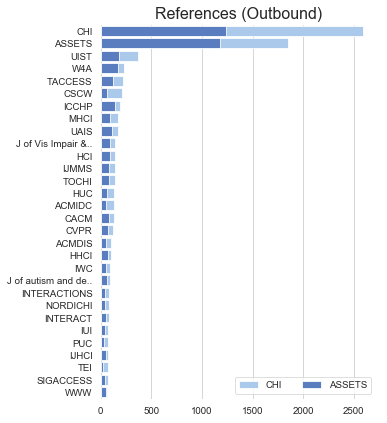

In [31]:
# Plot top venues among references
plt.close()
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (5.5,6))
sns.set_color_codes('pastel')
sns.barplot(x = 'Total', y = 'Venue', data = df_refs,
            label = 'CHI', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'ASSETS', y = 'Venue', data = df_refs,
            label = 'ASSETS', color = 'b', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)

# Iterate thorugh each axis
ax.set_title('References (Outbound)', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

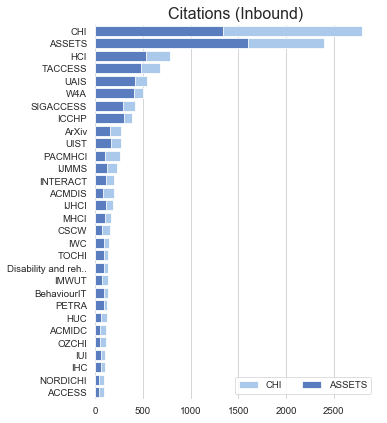

In [33]:
# Plot top venues among citations
plt.close()
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (5.5,6))
sns.set_color_codes('pastel')
sns.barplot(x = 'Total', y = 'Venue', data = df_cits,
            label = 'CHI', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'ASSETS', y = 'Venue', data = df_cits,
            label = 'ASSETS', color = 'b', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)

# Iterate thorugh each axis
ax.set_title('Citations (Inbound)', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

## Top MAG L1 fields of study among references and citations for accessibility papers in core set

In [34]:
# Setup dataframe
def get_top_fos(fos_list):
    if not fos_list:
        return None
    fos_list.sort(key = lambda x: x[-1], reverse=True)
    return fos_list[0][2]

def get_fos_weighted_tuple(fos_list):
    if not fos_list:
        return None
    wt = 1. / len(fos_list)
    return [(fos[0], wt) for fos in fos_list]

# histogram
top_k = 30

# Most commonly referenced and citing papers
a11y_assets_refs = flatten([paper.refs for paper in core['a11y_assets']])
a11y_assets_cits = flatten([paper.cits for paper in core['a11y_assets']])

a11y_chi_refs = flatten([paper.refs for paper in core['a11y_chi']])
a11y_chi_cits = flatten([paper.cits for paper in core['a11y_chi']])

a11y_assets_ref_papers = [lookup.get_paper_by_triple(tuple(ref)) for ref in a11y_assets_refs if ref]
a11y_assets_cit_papers = [lookup.get_paper_by_triple(tuple(cit)) for cit in a11y_assets_cits if cit]

a11y_chi_ref_papers = [lookup.get_paper_by_triple(tuple(ref)) for ref in a11y_chi_refs if ref]
a11y_chi_cit_papers = [lookup.get_paper_by_triple(tuple(cit)) for cit in a11y_chi_cits if cit]

a11y_assets_all_ref_fos = [('ASSETS', get_fos_weighted_tuple(p.l1_fos)) for p in a11y_assets_ref_papers]
a11y_chi_all_ref_fos = [('CHI', get_fos_weighted_tuple(p.l1_fos)) for p in a11y_chi_ref_papers]

a11y_assets_all_cit_fos = [('ASSETS', get_fos_weighted_tuple(p.l1_fos)) for p in a11y_assets_cit_papers]
a11y_chi_all_cit_fos = [('CHI', get_fos_weighted_tuple(p.l1_fos)) for p in a11y_chi_cit_papers]

# get top k fos
all_ref_counts = defaultdict(float)
all_cit_counts = defaultdict(float)

for entry in a11y_assets_all_ref_fos + a11y_chi_all_ref_fos:
    if not entry[1]:
        continue
    for fos_id, wt in entry[1]:
        all_ref_counts[fos_id] += wt
        
for entry in a11y_assets_all_cit_fos + a11y_chi_all_cit_fos:
    if not entry[1]:
        continue
    for fos_id, wt in entry[1]:
        all_cit_counts[fos_id] += wt
        
ref_counts_most_common = sorted([(k, v) for k, v in all_ref_counts.items()], key=lambda x: x[1], reverse=True)
cit_counts_most_common = sorted([(k, v) for k, v in all_cit_counts.items()], key=lambda x: x[1], reverse=True)

top_k_ref_fos = [(
    fos_id, 
    mag_lookup.get_name(mag_lookup.get_l0(fos_id)[0])
) for fos_id, count in ref_counts_most_common[:top_k + 1] if v_str]
top_k_cit_fos = [(
    fos_id, 
    mag_lookup.get_name(mag_lookup.get_l0(fos_id)[0])
) for fos_id, count in cit_counts_most_common[:top_k + 1] if v_str]

# get assets and chi counts
assets_ref_counts = defaultdict(float)
assets_cit_counts = defaultdict(float)

for entry in a11y_assets_all_ref_fos:
    if not entry[1]:
        continue
    for fos_id, wt in entry[1]:
        assets_ref_counts[fos_id] += wt
        
for entry in a11y_assets_all_cit_fos:
    if not entry[1]:
        continue
    for fos_id, wt in entry[1]:
        assets_cit_counts[fos_id] += wt
        
chi_ref_counts = defaultdict(float)
chi_cit_counts = defaultdict(float)

for entry in a11y_chi_all_ref_fos:
    if not entry[1]:
        continue
    for fos_id, wt in entry[1]:
        chi_ref_counts[fos_id] += wt
        
for entry in a11y_chi_all_cit_fos:
    if not entry[1]:
        continue
    for fos_id, wt in entry[1]:
        chi_cit_counts[fos_id] += wt

# create data to plot
bars_to_plot_refs = []
bars_to_plot_cits = []
for fos_id, fos_l0 in top_k_ref_fos:
    num_refs_assets = assets_ref_counts.get(fos_id, 0)
    num_refs_chi = chi_ref_counts.get(fos_id, 0)
    bars_to_plot_refs.append((
        'References', 
        mag_lookup.get_name(fos_id), 
        fos_l0,
        num_refs_assets, 
        num_refs_chi, 
        num_refs_assets + num_refs_chi
    ))
    
for fos_id, fos_l0 in top_k_cit_fos:
    num_cits_assets = assets_cit_counts.get(fos_id, 0)
    num_cits_chi = chi_cit_counts.get(fos_id, 0)
    bars_to_plot_cits.append((
        'Citations', 
        mag_lookup.get_name(fos_id), 
        fos_l0,
        num_cits_assets, 
        num_cits_chi, 
        num_cits_assets + num_cits_chi
    ))

df_refs = DataFrame(bars_to_plot_refs, columns=['Type', 'Field of study', 'L0', 'ASSETS', 'CHI', 'Total'])
df_cits = DataFrame(bars_to_plot_cits, columns=['Type', 'Field of study', 'L0', 'ASSETS', 'CHI', 'Total'])
df = DataFrame(bars_to_plot_refs + bars_to_plot_cits, columns=['Type', 'Field of study', 'L0', 'ASSETS', 'CHI', 'Total'])

display(df)

,Type,Field of study,L0,ASSETS,CHI,Total
0,References,human computer interaction,computer science,1794.583333,1335.166667,3129.750000
1,References,multimedia,computer science,1557.833333,1124.333333,2682.166667
2,References,world wide web,computer science,774.333333,404.000000,1178.333333
3,References,artificial intelligence,computer science,708.533333,371.250000,1079.783333
4,References,speech recognition,computer science,587.450000,291.833333,879.283333
...,...,...,...,...,...,...
57,Citations,pedagogy,psychology,81.333333,62.500000,143.833333
58,Citations,physical therapy,medicine,53.166667,82.500000,135.666667
59,Citations,linguistics,philosophy,110.916667,11.333333,122.250000
60,Citations,engineering management,engineering,65.000000,48.500000,113.500000


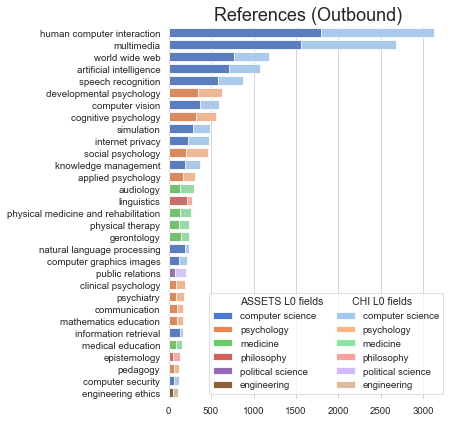

In [38]:
# Plot top MAG FoS among references
plt.close()
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (6.5,6))

sns.set_color_codes('pastel')
palette1 = {k: v for k, v in zip(df_refs['L0'].unique(), itertools.cycle(sns.color_palette("pastel")))}
colors1 = [palette1[l0] for l0 in df_refs['L0']]
sns.barplot(x = 'Total', y = 'Field of study', palette = colors1, 
            data = df_refs, edgecolor = 'w')

sns.set_color_codes('muted')
palette2 = {k: v for k, v in zip(df_refs['L0'].unique(), itertools.cycle(sns.color_palette("muted")))}
colors2 = [palette2[l0] for l0 in df_refs['L0']]
sns.barplot(x = 'ASSETS', y = 'Field of study', palette = colors2, 
            data = df_refs, edgecolor = 'w')

legend_elements = [Patch(facecolor=clr, edgecolor='w',
         label=l0) for l0, clr in palette2.items()] + [Patch(facecolor=clr, edgecolor='w',
         label=l0) for l0, clr in palette1.items()]
ax.legend(handles=legend_elements, title="ASSETS L0 fields          CHI L0 fields", ncol = 2, loc = 'lower right')

sns.despine(left = True, bottom = True)

# Iterate thorugh each axis
ax.set_title('References (Outbound)', fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

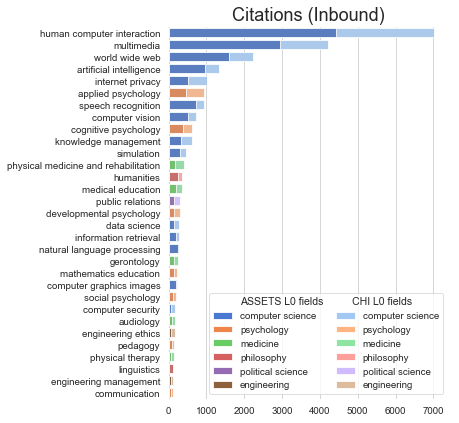

In [39]:
# Plot top MAG FoS among citations
plt.close()
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (6.5,6))

sns.set_color_codes('pastel')
palette1 = {k: v for k, v in zip(df_cits['L0'].unique(), itertools.cycle(sns.color_palette("pastel")))}
colors1 = [palette1[l0] for l0 in df_cits['L0']]
sns.barplot(x = 'Total', y = 'Field of study', palette = colors1, 
            data = df_cits, edgecolor = 'w')

sns.set_color_codes('muted')
palette2 = {k: v for k, v in zip(df_cits['L0'].unique(), itertools.cycle(sns.color_palette("muted")))}
colors2 = [palette2[l0] for l0 in df_cits['L0']]
sns.barplot(x = 'ASSETS', y = 'Field of study', palette = colors2, 
            data = df_cits, edgecolor = 'w')

legend_elements = [Patch(facecolor=clr, edgecolor='w',
         label=l0) for l0, clr in palette2.items()] + [Patch(facecolor=clr, edgecolor='w',
         label=l0) for l0, clr in palette1.items()]
# ax.legend(handles=legend_elements, title="$\\bf{ASSETS\ L0\ FoS\ \ \ \ \ \ CHI\ L0\ FoS}$", ncol = 2, loc = 'lower right')
ax.legend(handles=legend_elements, title="ASSETS L0 fields          CHI L0 fields", ncol = 2, loc = 'lower right')

sns.despine(left = True, bottom = True)

# Iterate thorugh each axis
ax.set_title('Citations (Inbound)', fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

## Trends in MAG L0 field of study representation over time

/Users/lucyw/miniconda3/envs/a11y_bibliometric_analysis/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


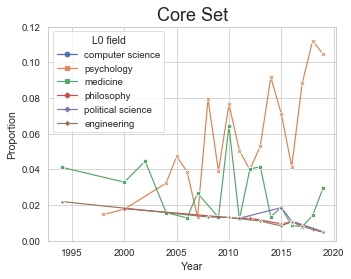

In [49]:
# PLOT L1 FOS IN A11Y PAPERS CHANGE OVER TIME (JUST CORE PAPERS!)
keep_fos = ['computer science', 'psychology', 'medicine', 'philosophy', 'political science', 'engineering']

# Most commonly referenced and citing papers
a11y_fos_by_year = {
    'a11y': defaultdict(lambda: defaultdict(float)),
    'ASSETS': defaultdict(lambda: defaultdict(float)),
    'CHI': defaultdict(lambda: defaultdict(float)),
    'total': defaultdict(int),
    'num_papers': defaultdict(int)
}
for fos in keep_fos:
    a11y_fos_by_year['a11y'][1994][fos] = 0
    a11y_fos_by_year['CHI'][1994][fos] = 0
    a11y_fos_by_year['ASSETS'][1994][fos] = 0 
a11y_fos_by_year['total'][1994] = 0
a11y_fos_by_year['num_papers'][1994] = 0

for paper in core['a11y']:
    if paper.l1_fos:
        for fos_id, wt, _, _, _ in paper.l1_fos:
            fos_l0 = mag_lookup.get_l0(fos_id)[0]
            if paper.venue == 'conf/chi':
                a11y_fos_by_year['CHI'][paper.year][fos_l0] += wt
            elif paper.venue == 'conf/assets':
                a11y_fos_by_year['ASSETS'][paper.year][fos_l0] += wt
            a11y_fos_by_year['a11y'][paper.year][fos_l0] += wt
        a11y_fos_by_year['total'][paper.year] += 1
    a11y_fos_by_year['num_papers'][paper.year] += 1
            
data_to_plot = []
for year, fos_counts in a11y_fos_by_year['a11y'].items():
    for fos_id, count in fos_counts.items():
        if a11y_fos_by_year['num_papers'][year] >= 5:
            data_to_plot.append([
                year, 
                mag_lookup.get_name(fos_id),  
                count / a11y_fos_by_year['total'][year]
            ])

years_to_keep = {k for k, v in a11y_fos_by_year['num_papers'].items() if v >= 5}
data_to_plot = [
    entry for entry in data_to_plot 
    if entry[1] in keep_fos and entry[0] in years_to_keep
]
data_to_plot.sort(key=lambda x: keep_fos.index(x[1]))
        
df_refs = DataFrame(data_to_plot, columns=['Year', 'L0 field', 'Proportion'])
   
plt.close()
f, ax = plt.subplots(figsize = (5,4))
ax.set_ylim([0, 0.12])
col = np.array(sns.color_palette())
sns.lineplot(
    data=df_refs,
    x="Year", y="Proportion", hue="L0 field", style="L0 field",
    markers=True, dashes=False,
    palette=col
)
ax.set_title('Core Set', fontsize=18)
# ax.get_legend().remove()
plt.tight_layout()
plt.show()


/Users/lucyw/miniconda3/envs/a11y_bibliometric_analysis/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


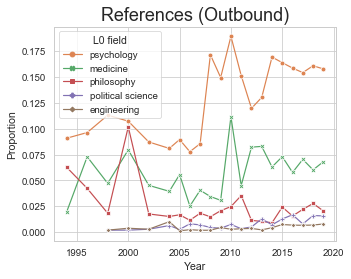

In [41]:
# FoS trends over time for references
keep_fos = ['computer science', 'psychology', 'medicine', 'philosophy', 'political science', 'engineering']
top_k_ref_fos_non_cs = [entry[0] for entry in top_k_ref_fos if entry[1] != 'computer science']

# Most commonly referenced and citing papers
a11y_ref_fos_by_year = {
    'a11y': defaultdict(lambda: defaultdict(float)),
    'ASSETS': defaultdict(lambda: defaultdict(float)),
    'CHI': defaultdict(lambda: defaultdict(float)),
    'total': defaultdict(int),
    'num_papers': defaultdict(int)
}
for paper in core['a11y']:
    for ref in paper.refs:
        ref_paper = lookup.get_paper_by_triple(tuple(ref))
        ref_fos = get_fos_weighted_tuple(ref_paper.l1_fos)
        if ref_fos:
            for fos_id, wt in ref_fos:
                fos_l0 = mag_lookup.get_l0(fos_id)[0]
                if fos_id in top_k_ref_fos_non_cs:
                    if paper.venue == 'conf/chi':
                        a11y_ref_fos_by_year['CHI'][paper.year][fos_l0] += wt
                    elif paper.venue == 'conf/assets':
                        a11y_ref_fos_by_year['ASSETS'][paper.year][fos_l0] += wt
                    a11y_ref_fos_by_year['a11y'][paper.year][fos_l0] += wt
            a11y_ref_fos_by_year['total'][paper.year] += 1
    a11y_ref_fos_by_year['num_papers'][paper.year] += 1
            
data_to_plot = []
for year, fos_counts in a11y_ref_fos_by_year['a11y'].items():
    for fos_id, count in fos_counts.items():
        if a11y_ref_fos_by_year['num_papers'][year] >= 5:
            data_to_plot.append([
                year, 
                mag_lookup.get_name(fos_id), 
                count / a11y_ref_fos_by_year['total'][year]
            ])
            
data_to_plot.sort(key=lambda x: keep_fos.index(x[1]))
        
df_refs = DataFrame(data_to_plot, columns=['Year', 'L0 field', 'Proportion'])
   
plt.close()
f, ax = plt.subplots(figsize = (5,4))
col = np.array(sns.color_palette())[1:]
sns.lineplot(
    data=df_refs,
    x="Year", y="Proportion", hue="L0 field", style="L0 field",
    markers=True, dashes=False,
    palette=col
)
ax.set_title('References (Outbound)', fontsize=18)
# ax.get_legend().remove()
plt.tight_layout()
plt.show()


/Users/lucyw/miniconda3/envs/a11y_bibliometric_analysis/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


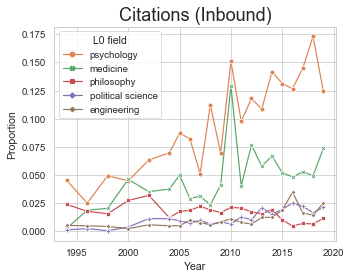

In [42]:
# FoS trends over time for citations
keep_fos = ['computer science', 'psychology', 'medicine', 'philosophy', 'political science', 'engineering']
top_k_cit_fos_non_cs = [entry[0] for entry in top_k_cit_fos if entry[1] != 'computer science']

# Most commonly referenced and citing papers
a11y_cit_fos_by_year = {
    'a11y': defaultdict(lambda: defaultdict(float)),
    'ASSETS': defaultdict(lambda: defaultdict(float)),
    'CHI': defaultdict(lambda: defaultdict(float)),
    'total': defaultdict(int),
    'num_papers': defaultdict(int)
}
for paper in core['a11y']:
    for cit in paper.cits:
        cit_paper = lookup.get_paper_by_triple(tuple(cit))
        cit_fos = get_fos_weighted_tuple(cit_paper.l1_fos)
        if cit_fos:
            for fos_id, wt in cit_fos:
                fos_l0 = mag_lookup.get_l0(fos_id)[0]
                if fos_id in top_k_cit_fos_non_cs:
                    if paper.venue == 'conf/chi':
                        a11y_cit_fos_by_year['CHI'][paper.year][fos_l0] += wt
                    elif paper.venue == 'conf/assets':
                        a11y_cit_fos_by_year['ASSETS'][paper.year][fos_l0] += wt
                    a11y_cit_fos_by_year['a11y'][paper.year][fos_l0] += wt
            a11y_cit_fos_by_year['total'][paper.year] += 1
    a11y_cit_fos_by_year['num_papers'][paper.year] += 1
            
data_to_plot = []
for year, fos_counts in a11y_cit_fos_by_year['a11y'].items():
    for fos_id, count in fos_counts.items():
        if a11y_cit_fos_by_year['num_papers'][year] >= 5:
            data_to_plot.append([
                year, 
                mag_lookup.get_name(fos_id), 
                count / a11y_cit_fos_by_year['total'][year]
            ])
            
data_to_plot.sort(key=lambda x: keep_fos.index(x[1]))
        
df_cits = DataFrame(data_to_plot, columns=['Year', 'L0 field', 'Proportion'])
   
plt.close()
f, ax = plt.subplots(figsize = (5,4))
col = np.array(sns.color_palette())[1:]
sns.lineplot(
    data=df_cits,
    x="Year", y="Proportion", hue="L0 field", style="L0 field",
    markers=True, dashes=False,
    palette=col
)
ax.set_title('Citations (Inbound)', fontsize=18)
# ax.get_legend().remove()
plt.tight_layout()
plt.show()


## LCDI diversity analysis

Plot the LCDI over the MAG fields of study for the references and citations of all papers in each comparative venues. The data used in this section is generated by the script `scripts/get_lcdi_scores.py`.

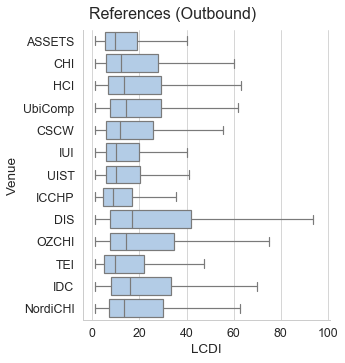

In [50]:
# LCDI for references
with open('data/analysis/lcdi_refs_by_papers_l1.json', 'r') as f:
    lcdi_refs = json.load(f)

plt.close()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)

data_to_plot = []
for voi in VENUES_TO_PLOT:
    conf_name = dblp_info[voi]['acronym']
    lcdi_vals = list(lcdi_refs[voi].values())
    for lcdi in lcdi_vals:
        data_to_plot.append((conf_name, lcdi))
        
df = DataFrame(data_to_plot,columns=['Venue', 'LCDI'])
g = sns.catplot(x="LCDI", y="Venue", kind="box", data=df, color='#AACCEE', showfliers = False)
g.set(xlim=(-4, 101))
g.fig.suptitle("References (Outbound)", fontsize=16, x=0.5, y=1.01, horizontalalignment='center')
plt.tight_layout()
plt.show()


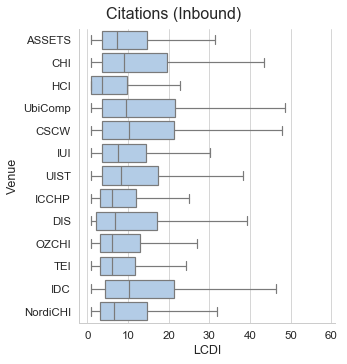

In [51]:
# LCDI for citations
with open('data/analysis/lcdi_cits_by_papers_l1.json', 'r') as f:
    lcdi_cits = json.load(f)
    
plt.close()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

data_to_plot = []
venue_names = []
for voi in VENUES_TO_PLOT:
    conf_name = dblp_info[voi]['acronym']
    lcdi_vals = list(lcdi_cits[voi].values())
    for lcdi in lcdi_vals:
        data_to_plot.append((conf_name, lcdi))
        
df = DataFrame(data_to_plot,columns=['Venue', 'LCDI'])
g = sns.catplot(x="LCDI", y="Venue", kind="box", data=df, color='#AACCEE', showfliers = False)
g.set(xlim=(-2, 61))
g.fig.suptitle("Citations (Inbound)", fontsize=16, x=0.5, y=1.01, horizontalalignment='center')
plt.tight_layout()
plt.show()
